In [252]:
from __future__ import print_function, division
%matplotlib inline
import sys
import emcee
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import numpy as np
from numpy import ma
from scipy import integrate, optimize, stats, special
import nestle
import corner

## Convenience functions

In [253]:
def flatten_without_burn(sampler, nburn, itemp=0):
    c = sampler.chain
    if c.ndim == 4:
        c = c[itemp]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))


def weight_without_burn(sampler, nburn, itemp=0):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[itemp]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


def lnprobability_without_burn(sampler, nburn, itemp=0):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[itemp]
    c = c[:, nburn:]
    w = c.reshape(np.product(c.shape))
    return w


def lnlikelihood_without_burn(sampler, nburn, itemp=0):
    c = sampler.lnlikelihood
    if c.ndim == 3:
        c = c[itemp]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()

In [254]:
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, par, truths=None):
    mean = samples.mean(0)
    sigma = samples.std(0)
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        outstr = ('{:16s} = {:8.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ({:8.'+dp+')').format(truths[i])
        print(outstr)
    return mean, sigma

In [255]:
def plot_chain(sampler, par, nburn=None, outfile=None):
    plt.figure(figsize=[20,10])
    nwalkers = sampler.chain.shape[1]
    if nburn is None:
        nburn = sampler.chain.shape[2]//10
    for i, p in enumerate(par):
        plt.subplot(2,2,i+1)
        for t in [0]: #range(ntemps):
            for w in range(nwalkers):
                plt.plot(np.arange(len(sampler.chain[t,0,:,0])), sampler.chain[t,w,:,i], 'r-', alpha=1.0/nwalkers)
        plt.xlabel(p)
        aymin, aymax = plt.ylim()
        plt.vlines(nburn, aymin, aymax, linestyle=':')
        plt.ylim(aymin, aymax)
    if outfile is not None:
        plt.savefig(outfile)


def plot_hist(sampler, par, nburn=None, weights=None, outfile=None):
    plt.figure(figsize=[20,10])
    if nburn is None:
        nburn = sampler.chain.shape[2]//10
    nrow = int(ceil(len(par)/2.0))
    for i, p in enumerate(par):
        plt.subplot(nrow, 2, i+1)
        plt.hist(flatten_without_burn(sampler, nburn)[:,i], weights=weights,
                 bins=100, histtype='stepfilled', alpha=0.75)
        plt.xlabel(p)
    if outfile is not None:
        plt.savefig(outfile)


def plot_func(sampler, model, xmin, xmax, xdata, ydata, yerror,
              nburn=None, outfile=None, model_pars=[]):
    if nburn is None:
        nburn = sampler.chain.shape[2]//10
    xchain = np.arange(xmin, xmax, 1.0)
    ychain = [model(xchain, p, *model_pars)
              for p in flatten_without_burn(sampler, nburn)]
    plt.figure(figsize=[20,10])
    plt.errorbar(xdata, ydata, yerror, None, 'o')
    for i, y in enumerate(ychain[::100]):
        plt.plot(xchain, y, '-', alpha=0.1, c='green')
    plt.xlim(xmin, xmax)
    if outfile is not None:
        plt.savefig(outfile)


def plot_triangle(sampler, par, model, xmin, xmax, xdata, ydata, yerror,
              nburn=None, outfile=None, model_pars=[], itemp=0):
    if nburn is None:
        nburn = sampler.chain.shape[2]//10
    pchain = flatten_without_burn(sampler, nburn, itemp)
    xchain = np.linspace(xmin, xmax, 100)
    ychain = [model(xchain, p, *model_pars) for p in pchain]
    if len(par) == 1:
        plt.subplot(1, 2, 1)
        plt.hist(pchain[:,0], bins=100, histtype='stepfilled', alpha=0.75)
        plt.subplot(1, 2, 2)
    else:
        corner.corner(pchain, labels=par)
        if len(par) % 2 == 0:
            n = 2
        else:
            n = int(ceil(len(par)/2.0)) + 1
        plt.subplot(n, n, n)
    for y in ychain[::100]:
        plt.plot(xchain, y, 'r-', alpha=1000.0/len(ychain))
    plt.errorbar(xdata, ydata, yerror, None, 'o')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    if outfile is not None:
        plt.savefig(outfile)

In [256]:
def autocor_checks(sampler, aper, field, glx, nburn, label=''):
    a_exp = sampler.acor[0]
    a_int = np.max([emcee.autocorr.integrated_time(sampler.chain[0, i, nburn:])
                    for i in range(len(sampler.chain[0]))], 0)
    a_exp = max(a_exp)
    a_int = max(a_int)
    print('A reasonable burn-in should be around {:d} steps'.format(int(10*a_exp)))
    print('After burn-in, each chain produces one independent sample per {:d} steps'.format(int(a_int)))

    g = [emcee.autocorr.function(sampler.chain[0, i, :nburn])
         for i in range(3)]

    ax = plt.figure().add_subplot(111)
    for i in range(3):
        ax.plot(g[i][:200], "k")
    ax.axhline(0, color="k")
    ax.set_xlim(0, 200)
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Autocorrelation")
    plt.savefig((output_path + 'F{field}_mcmc_burnin_acor_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))

   ### Autocorrelation for AFTER the burn-in

    f = [emcee.autocorr.function(sampler.chain[0, i, nburn:])
         for i in range(3)]

    ax = plt.figure().add_subplot(111)
    for i in range(3):
        ax.plot(f[i][:200], "k")
    ax.axhline(0, color="k")
    ax.set_xlim(0, 200)
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Autocorrelation")
    plt.savefig((output_path + 'F{field}_mcmc_acor_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))

    ### gk_i es la suma de todos los valores anteriores del parametro gk en la cadena i dividido entre el numero de valores. Vamos, un valor medio.

    ### gk_twodots es la suma de todos los valores anteriores de gk en todas las cadenas dividido entre numero total de cadenas multiplicado por el numero de iterations.

    all_R_k = []
    gk_all = []
    B_over_q_each = []
    W_each = []

    # I SUSPECT THIS IS SLOW - ISN'T THERE A BETTER WAY?
    for qq in range(0,nsamp):
        for ll in range(0,nwalkers):

            gk_ll = sum(sampler.chain[0,ll,:qq,0])/nsamp
            gk_twodots = sum(sum(sampler.chain[0,:,:qq,0]))/(nsamp*nwalkers)

	    gk_ll_qq = sampler.chain[0,ll,qq,0]
            W_each.append((gk_ll_qq - gk_ll)**2)

            B_over_q_each.append(((gk_ll - gk_twodots)**2))

        B_over_q_total = sum(B_over_q_each)/(nwalkers-1)
        W_total = sum(W_each)/(nwalkers*(qq - 1))
        sigma_2_plus = (qq - 1)*W_total/qq + B_over_q_total

        all_R_k.append((sigma_2_plus + B_over_q_total/nwalkers)/W_total)

    f1 = open((output_path + 'F{field}_gal_{label}_{glx}_convergence_test.txt').format(
        aper=aper, field=field, glx=glx, label=label), 'a+')
    for hh in range(0,len(all_R_k)):
        f1.write('%5i %.3f\n'%(hh,all_R_k[hh]))
    f1.close()

    ax = plt.figure().add_subplot(111)
    ax.plot(all_R_k)
    plt.savefig((output_path + 'F{field}_gal_{label}_{glx}_convergence_test.pdf').format(
        aper=aper, field=field, glx=glx, label=label))
    return a_exp, a_int


def acc_frac_checks(sampler, aper, field, glx, label=''):
    acc_frac = np.mean(sampler.acceptance_fraction)
    f1 = open((output_path + 'F{field}_gal_{label}_{glx}_acceptance_fractions.txt').format(
        aper=aper, field=field, glx=glx, label=label), 'a+')
    f1.write('%5i %.3f\n'%(glx, acc_frac))
    f1.close()
    print("Mean acceptance fraction: {0:.3f}".format(acc_frac))
    return acc_frac

## Speed test

In [4]:
def lnprior_continuum0(continuum):
    # proper prior on continuum
    # same as flat model
    return stats.norm.logpdf(continuum, 45, 27.5)


lnprior_continuum_dist = stats.norm(45, 27.5)
def lnprior_continuum1(continuum):
    return lnprior_continuum_dist.logpdf(continuum)


_norm_pdf_C = np.sqrt(2*pi)
_norm_pdf_logC = np.log(_norm_pdf_C)

def norm_logpdf1(x, loc=0, scale=1):
    return -0.5 * np.sum(np.log(2 * np.pi * scale ** 2)
                         + (x - loc) ** 2 / scale ** 2)

def lnprior_continuum2(continuum):
    return norm_logpdf1(continuum, 45, 27.5)


def norm_logpdf2(x, loc=0, scale=1):
    y = (x - loc) / scale
    z = -y**2 / 2.0 - _norm_pdf_logC
    return np.sum(z - np.log(scale))

def lnprior_continuum3(continuum):
    return norm_logpdf2(continuum, 45, 27.5)


def norm_logpdf3(x, loc=0, scale=1):
    y = (x - loc) / scale
    z = -y**2 / 2.0 - _norm_pdf_logC
    return z - np.log(scale)

def lnprior_continuum4(continuum):
    return norm_logpdf3(continuum, 45, 27.5)


class NormLogPDF:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.a = np.sum(np.log(2 * np.pi * scale ** 2))
        self.b = scale ** 2
    def __call__(self, x):
        return -0.5 * (self.a + np.sum((x - self.loc) ** 2) / self.b)

lnprior_continuum_instance = NormLogPDF(45, 27.5)
def lnprior_continuum5(continuum):
    return lnprior_continuum_instance(continuum)    

In [5]:
print(lnprior_continuum0(10.0),
      lnprior_continuum1(10.0),
      lnprior_continuum2(10.0),
      lnprior_continuum3(10.0),
      lnprior_continuum4(10.0),
      lnprior_continuum5(10.0))

-5.04304189325 -5.04304189325 -5.04304189325 -5.04304189325 -5.04304189325 -5.04304189325


In [6]:
%timeit -n10000 lnprior_continuum0(10.0)

10000 loops, best of 3: 80.4 µs per loop


In [7]:
%timeit -n10000 lnprior_continuum1(10.0)

10000 loops, best of 3: 51.1 µs per loop


In [8]:
%timeit -n100000 lnprior_continuum2(10.0)

100000 loops, best of 3: 5.46 µs per loop


In [9]:
%timeit -n100000 lnprior_continuum3(10.0)

100000 loops, best of 3: 6.84 µs per loop


In [10]:
%timeit -n100000 lnprior_continuum4(10.0)

100000 loops, best of 3: 1.2 µs per loop


In [11]:
%timeit -n100000 lnprior_continuum5(10.0)

100000 loops, best of 3: 6.87 µs per loop


In [12]:
x = 3
np.where(x<0, -np.inf, x)

array(3.0)

In [13]:
def lnprior_fluxNII0(fluxNII, ymax):
    return stats.gamma.logpdf(fluxNII, a=1.0, scale=ymax)

def gamma_logpdf1(x, a, loc=0, scale=1):
    x = np.asarray((x - loc) / scale)
    if (x < 0).any():
        return -np.inf
    z = special.xlogy(a - 1.0, x) - x - special.gammaln(a)
    z = np.sum(z - np.log(scale))
    return z

def lnprior_fluxNII1(fluxNII, ymax):
    return gamma_logpdf1(fluxNII, a=1.0, scale=ymax)

def gamma_logpdf2(x, a, loc=0, scale=1):
    x = (x - loc) / scale
    z = special.xlogy(a - 1.0, x) - x - special.gammaln(a)
    z -= np.log(scale)
    z = np.where(x < 0, -np.inf, z)
    if z.ndim == 0:
        return z[()]
    return z

def lnprior_fluxNII2(fluxNII, ymax):
    return gamma_logpdf2(fluxNII, a=1.0, scale=ymax)

In [14]:
print(lnprior_fluxNII0(1.0, 10.0),
      lnprior_fluxNII1(1.0, 10.0),
      lnprior_fluxNII2(1.0, 10.0))

print(lnprior_fluxNII0(-1.0, 10.0),
      lnprior_fluxNII1(-1.0, 10.0),
      lnprior_fluxNII2(-1.0, 10.0))

print(lnprior_fluxNII0(np.array([-1.0, 1.0]), 10.0),
      lnprior_fluxNII1(np.array([-1.0, 1.0]), 10.0),
      lnprior_fluxNII2(np.array([-1.0, 1.0]), 10.0))

-2.40258509299 -2.40258509299 -2.40258509299
-inf -inf -inf
[       -inf -2.40258509] -inf [       -inf -2.40258509]


In [15]:
%timeit -n10000 lnprior_fluxNII0(1.0, 10.0)

10000 loops, best of 3: 68.2 µs per loop


In [16]:
%timeit -n100000 lnprior_fluxNII1(1.0, 10.0)

100000 loops, best of 3: 9.74 µs per loop


In [17]:
%timeit -n100000 lnprior_fluxNII2(1.0, 10.0)

100000 loops, best of 3: 6.32 µs per loop


In [18]:
def beta_logpdf1(x, a, b, loc=0, scale=1):
    x = (x - loc) / scale
    z = special.xlog1py(b - 1.0, -x) + special.xlogy(a - 1.0, x)
    z -= special.betaln(a, b) + np.log(scale)
    z = np.where((x < 0) | (x > 1), -np.inf, z)
    if z.ndim == 0:
        return z[()]
    return z

In [19]:
print(stats.beta.logpdf(np.array([0.12, 0.15, 0.17]), 1.4, 1.4, 0.14, 0.02),
      beta_logpdf1(np.array([0.12, 0.15, 0.17]), 1.4, 1.4, 0.14, 0.02))

[       -inf  4.11343388        -inf] [       -inf  4.11343388        -inf]


In [20]:
%timeit -n10000 stats.beta.logpdf(np.array([0.12, 0.15, 0.17]), 1.4, 1.4, 0.14, 0.02)

10000 loops, best of 3: 74.1 µs per loop


In [21]:
%timeit -n100000 beta_logpdf1(np.array([0.12, 0.15, 0.17]), 1.4, 1.4, 0.14, 0.02)

100000 loops, best of 3: 12.5 µs per loop


## Fast pdf functions

In [257]:
_norm_pdf_C = np.sqrt(2*pi)
_norm_pdf_logC = np.log(_norm_pdf_C)

def norm_pdf(x, loc=0, scale=1):
    y = (x - loc) / scale
    z = np.exp(-y**2 / 2.0) / _norm_pdf_C
    return z / scale

def norm_logpdf(x, loc=0, scale=1):
    y = (x - loc) / scale
    z = -y**2 / 2.0 - _norm_pdf_logC
    return z - np.log(scale)

def gamma_logpdf(x, a, loc=0, scale=1):
    x = (x - loc) / scale
    z = special.xlogy(a - 1.0, x) - x - special.gammaln(a)
    z -= np.log(scale)
    z = np.where(x < 0, -np.inf, z)
    if z.ndim == 0:
        return z[()]
    return z

def beta_logpdf(x, a, b, loc=0, scale=1):
    x = (x - loc) / scale
    z = special.xlog1py(b - 1.0, -x) + special.xlogy(a - 1.0, x)
    z -= special.betaln(a, b)
    z -= np.log(scale)
    z = np.where((x < 0) | (x > 1), -np.inf, z)
    if z.ndim == 0:
        return z[()]
    return z

## Models

In [258]:
wlHa = 6562.8
wlNIIa = 6548.1
wlNIIb = 6583.5
NIIratio = 3.06
linewidth = 7.5

In [259]:
def fixha_model(x, p):
    p = np.atleast_2d(p)
    continuum, redshift, fluxHa, fluxNII = p.T
    zfactor = 1 + redshift
    model = continuum + norm_pdf(x, zfactor*wlHa, linewidth) * fluxHa
    model += (norm_pdf(x, zfactor*wlNIIa, linewidth) * fluxNII/NIIratio +
              norm_pdf(x, zfactor*wlNIIb, linewidth) * fluxNII)
    return model.squeeze()

par_fixha = ['continuum', 'redshift', 'flux Ha', 'flux NII']

In [260]:
def fixha_better_model(x, p):
    p = np.atleast_2d(p)
    continuum, redshift, fluxNII, NIIHa, absEWHa = p.T
    fluxHa = fluxNII / NIIHa - absEWHa * continuum
    zfactor = 1 + redshift
    model = continuum + norm_pdf(x, zfactor*wlHa, linewidth) * fluxHa
    model += (norm_pdf(x, zfactor*wlNIIa, linewidth) * fluxNII/NIIratio +
              norm_pdf(x, zfactor*wlNIIb, linewidth) * fluxNII)
    return model.squeeze()

par_fixha_better = ['continuum', 'redshift', 'flux NII', 'NII/Ha', 'abs EW Ha']

In [261]:
def flat_model(x, p):
    p = np.atleast_2d(p)
    return x * 0 +  p.T[0]

par_flat = ['continuum']

In [262]:
def line_model(x, p):
    p = np.atleast_2d(p)
    continuum, redshift, flux = p.T
    zfactor = 1 + redshift
    model = continuum + norm_pdf(x, zfactor*wlHa, linewidth) * flux
    return model.squeeze()

par_line = ['continuum', 'redshift', 'flux']

## Simulated data

In [90]:
ymax = 100
xmin = (1+0.14)*wlHa
xmax = (1+0.16)*wlHa

def sim_line(continuum=1, redshift=0.15, fluxHa=30, fluxNII=10, SN=10):
    x = np.linspace(xmin, xmax, 50)
    y_true = fixha_model(x, (continuum, redshift, fluxHa, fluxNII))
    sigma_true = continuum/float(SN)
    y_noisy = np.random.normal(y_true, sigma_true)
    return x, y_true, y_noisy, sigma_true

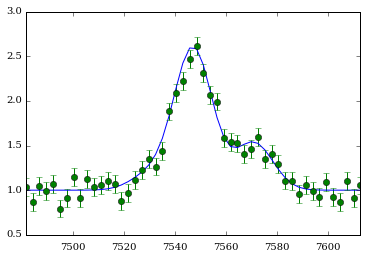

In [118]:
truths = (1, 0.15, 30, 10)
x, y_true, y_noisy, sigma_true = sim_line(*truths, SN=10)
sigma = sigma_true
plt.plot(x, y_true, '-')
plt.errorbar(x, y_noisy, sigma_true, fmt='o')
_ = plt.xlim(xmin, xmax)

## Priors

### Purposefully-informative priors

These are defined independently for each parameter, so they can be combined while maintaining normalisation.

In [179]:
def lnprior_continuum(continuum):
    # proper prior on continuum
    # same as flat model
    return norm_logpdf(continuum, 45, 27.5)

def lnprior_fluxNII(fluxNII, ymax):
    # proper prior on flux of NII line: flat with cutoff at high fluxes
    # flux > ymax disfavoured by lnL = -1
    # flux > 10*ymax disfavoured by lnL = -10
    # and positive definite
    return gamma_logpdf(fluxNII, a=1.0, scale=ymax)

def lnprior_NIIHa(NIIHa):
    # proper prior on NII/Ha ratio: peaked at ~0.5
    # fairly flat, with cutoffs
    # NII/Ha < 0.1 and > 3 disfavoured by lnL = -2.7
    # and positive definite
    return gamma_logpdf(NIIHa, a=2.7, scale=0.5)
    
def lnprior_absEWHa(absEWHa):
    # proper prior on EW of Ha absorption: peaked at ~0.5
    # fairly flat, with cutoffs
    # absEWHa > 3 disfavoured by lnL = -3
    # and positive definite
    return gamma_logpdf(absEWHa, a=1.0, scale=1.0)

def lnprior_redshift(redshift, xmin, xmax):
    # Set edges of redshift box (prior > 0.9) such that
    # peak of Halpha is in the wavelength range
    zmin = xmin/wlHa - 1
    zmax = xmax/wlHa - 1
    # Set cutoffwidth such that lnL ~ -2 by point at which
    # Halpha is out of wavelength range by 3 sigma
    c = 1.4
    cutoff = 3 * linewidth / wlHa
    loc = zmin - cutoff
    scale = zmax - zmin + 2 * cutoff
    return beta_logpdf(redshift, c, c, loc=loc, scale=scale)

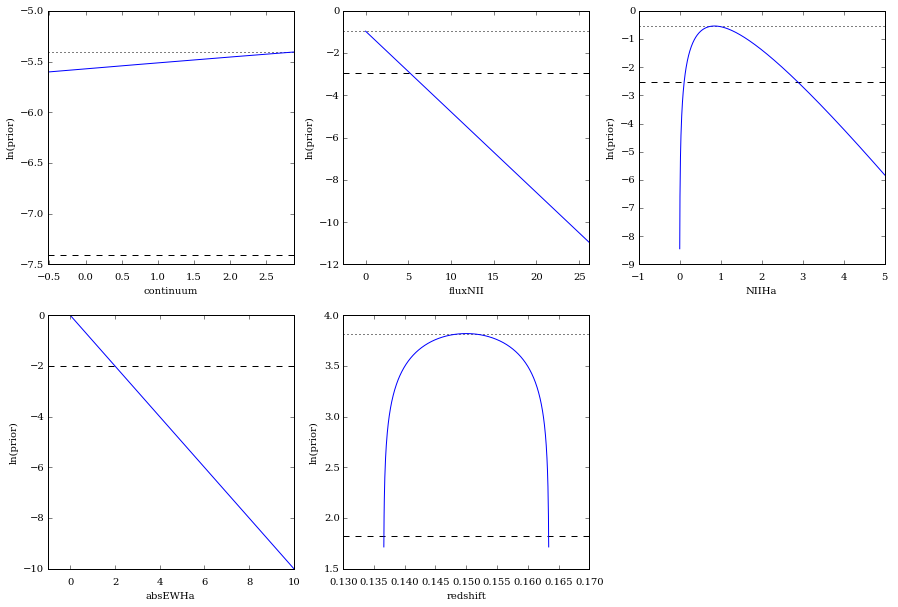

In [180]:
def plot_prior(ax, func, range, label, args=[]):
    x = np.linspace(range[0], range[1], 1000)
    lnprior = func(x, *args)
    ax.plot(x, lnprior)
    ax.set_xlim(range[0], range[1])
    ax.set_xlabel(label)
    ax.set_ylabel('ln(prior)')
    ax.hlines(lnprior.max(), range[0], range[1], linestyle='dotted')
    ax.hlines(lnprior.max() - 2, range[0], range[1], linestyle='dashed')

# set up plot
fig, axarr = plt.subplots(2, 3, figsize=(15, 10))
axarr = axarr.ravel()
_=axarr[5].axis('off')

plot_prior(axarr[0], lnprior_continuum, [-ymax/5.0, ymax*1.1], 'continuum')
plot_prior(axarr[1], lnprior_fluxNII, [-ymax, ymax*10], 'fluxNII', args=[ymax])
plot_prior(axarr[2], lnprior_NIIHa, [-1, 5], 'NIIHa')
plot_prior(axarr[3], lnprior_absEWHa, [-1, 10], 'absEWHa')
plot_prior(axarr[4], lnprior_redshift, [0.13, 0.17], 'redshift', args=[xmin, xmax])

In [181]:
def lnprior_fixha_better(p, xmin, xmax, ymax):
    p = np.atleast_2d(p)
    continuum, redshift, fluxNII, NIIHa, absEWHa = p.T
    lnprior = lnprior_continuum(continuum)
    lnprior += lnprior_fluxNII(fluxNII, ymax)
    lnprior += lnprior_NIIHa(NIIHa)
    lnprior += lnprior_absEWHa(absEWHa)
    lnprior += lnprior_redshift(redshift, xmin, xmax)
    return lnprior.squeeze()

In [182]:
def lnprior_fixha1_better(p):
    return lnprior_fixha_better(p, xmin, xmax, ymax)

fixha1_better_ranges = np.array([[-10, 100], [0.13, 0.17],
                                [-100, 1000], [-1, 10], [-10, 1]])

### Less-informative priors

Simpler priors for comparison and testing

In [34]:
def lnprior_uniform(ranges):
    rv = stats.uniform(ranges[:, 0], ranges[:, 1] - ranges[:, 0])
    def func(x):
        x = np.atleast_2d(x)
        lnP = rv.logpdf(x).sum(axis=1)
        return lnP.squeeze()
    return func

def lnprior_normal(ranges, trunc=False):
    mean = 0.5 * (ranges[:, 1] + ranges[:, 0])
    sigma = 0.25 * (ranges[:, 1] - ranges[:, 0])
    if trunc:
        rv = stats.truncnorm(-2, 2, mean, sigma)
    else:
        rv = stats.norm(mean, sigma)
    def func(x):
        x = np.atleast_2d(x)
        lnP = rv.logpdf(x).sum(axis=1)
        return lnP.squeeze()
    return func

In [35]:
fixha1_ranges = np.array([[-10, 100], [0.13, 0.17],
                          [-100, 1000], [-100, 1000]])
lnprior_fixha1_uniform = lnprior_uniform(fixha1_ranges)
lnprior_fixha1_normal = lnprior_normal(fixha1_ranges)

In [36]:
line_ranges = fixha1_ranges[0:3]
lnprior_line_uniform = lnprior_uniform(line_ranges)
lnprior_line_normal = lnprior_normal(line_ranges)
lnprior_line_truncnormal = lnprior_normal(line_ranges, trunc=True)

In [37]:
flat_ranges = fixha1_ranges[0:1]
lnprior_flat_uniform = lnprior_uniform(flat_ranges)
lnprior_flat_normal = lnprior_normal(flat_ranges)

### Check priors

#### Test various inputs

In [38]:
lnprior_flat_uniform(np.array([0]))

array(-4.700480365792417)

In [39]:
lnprior_flat_normal(np.array([0]))

array(-5.57196751308381)

In [40]:
lnprior_flat_uniform(np.array([[0], [-9]]))

array([-4.70048037, -4.70048037])

In [41]:
lnprior_flat_normal(np.array([[0], [-9]]))

array([-5.57196751, -6.16105842])

In [42]:
lnprior_line_uniform([[0, 0.15, 0], [1, 0.15, 100]])

array([-8.48467, -8.48467])

In [43]:
lnprior_line_normal([[0, 0.15, 0], [1, 0.15, 100]])

array([-9.76028847, -9.17251987])

In [44]:
lnprior_line_truncnormal([[0, 0.15, 0], [1, 0.15, 100]])

array([-9.62058473, -9.03281613])

In [45]:
lnprior_fixha1_uniform((0, 0.15, 0, 0))

array(-15.487735458497138)

In [46]:
lnprior_fixha1_normal((0, 0.15, 0, 0))

array(-17.634841072456105)

In [47]:
lnprior_fixha_better([(10, 0.15, 1, 0.5, 0.1), (10, 0.15, 10, 0.5, 0.1)], xmin, xmax, ymax)

array([-6.68123944, -6.77123944])

#### Normalisation

In [48]:
def expand_ranges(ranges, fraction):
    ranges = ranges.copy()
    range_widths = ranges[:,1] - ranges[:,0]
    ranges[:,0] -= fraction * range_widths
    ranges[:,1] += fraction * range_widths
    return ranges

In [49]:
# check prior is unit normalised
def check_unit_normalised_quad(lnfunc, ranges):
    def func(*p):
        return np.exp(lnfunc(p))
    ranges = expand_ranges(ranges, 0.00)
    integral, error = integrate.nquad(func, ranges)
    print(integral)
    return abs(integral - 1.0) < 1e-6

In [50]:
check_unit_normalised_quad(lnprior_flat_uniform, flat_ranges)

1.0


True

In [51]:
# too slow # check_unit_normalised_quad(lnprior_line_uniform, line_ranges)

In [52]:
def check_unit_normalised_nested(lnfunc, ranges):
    newranges = expand_ranges(ranges, 3)
    scale = newranges[:,1] - newranges[:,0]
    shift = newranges[:,0]
    def prior_transform(p):
        return scale * p + shift
    lnvol = np.log(np.product(newranges[:,1] - newranges[:,0]))
    res = nestle.sample(lnfunc, prior_transform,
                        len(ranges), method='single', npoints=1000, dlogz=0.001, enlarge=5*sqrt(len(ranges)))
    #print(res.summary)
    print('estimated evidence = {} +- {}'.format(res.logz, res.logzerr))
    logz = res.logz + lnvol
    print('prior volume corrected evidence = {}'.format(logz))
    return abs(logz) < 5*res.logzerr, res

In [53]:
%time success, nestle_flat_normal = check_unit_normalised_nested(lnprior_flat_normal, flat_ranges)

estimated evidence = -6.55470378925 +- 0.0429131834577
prior volume corrected evidence = 0.0916867255988
CPU times: user 7.48 s, sys: 67.9 ms, total: 7.54 s
Wall time: 8.04 s


In [54]:
%time success, nestle_line_normal = check_unit_normalised_nested(lnprior_line_normal, line_ranges)

estimated evidence = -14.2097344558 +- 0.0752500375182
prior volume corrected evidence = 0.112665991107
CPU times: user 31.9 s, sys: 358 ms, total: 32.3 s
Wall time: 22.1 s


In [55]:
%time success, nestle_fixha1_normal = check_unit_normalised_nested(lnprior_fixha1_normal, fixha1_ranges)

estimated evidence = -23.2528685074 +- 0.0875059155071
prior volume corrected evidence = 0.0185075473578
CPU times: user 39.3 s, sys: 276 ms, total: 39.6 s
Wall time: 24.9 s


In [138]:
def log_evidence(sampler, nburn):
    logls = sampler.lnlikelihood[:,:,nburn:]
    logls = ma.masked_array(logls, mask=logls == -np.inf)
    mean_logls = logls.mean(axis=-1).mean(axis=-1)
    logZ = -integrate.simps(mean_logls, sampler.betas)
    logZ2 = -integrate.simps(mean_logls[::2], sampler.betas[::2])
    logZerr = abs(logZ2 - logZ)
    print('\nestimated evidence = {} +- {}'.format(logZ, logZerr))
    return logZ, logZerr

In [57]:
def check_unit_normalised_emcee(lnfunc, ranges):
    ntemps = 50
    nwalkers = 50
    nburn = 500
    nsteps = 250
    niter = 10
    ndim = len(ranges)
    p0 = np.random.normal(size=(ntemps, nwalkers, 5))
    p0 = np.array([10.0, 0.15, 100.0, 1.0, 1.0]) + p0 * np.array([1.0, 0.001, 10.0, 0.1, 0.1])
    p0 = p0[:,:,:len(ranges)]
    newranges = expand_ranges(ranges, 3)
    prior = lnprior_uniform(newranges)
    prior0bad = (prior(p0) == -np.inf).sum()/np.product(p0.shape)
    if prior0bad > 0:
        print('Warning: {:.2f}% of initial parameters have zero prior'.format(prior0bad*100))
    lnfunc0bad = (lnfunc(p0) == -np.inf).sum()/np.product(p0.shape)
    if lnfunc0bad > 0:
        print('Warning: {:.2f}% of initial parameters have zero likelihood'.format(lnfunc0bad*100))
    sampler = emcee.PTSampler(ntemps, nwalkers, ndim, lnfunc, prior,
                              betas=np.logspace(0, -4, ntemps))
    pos = p0
    print('Steps:', end='')
    sys.stdout.flush()
    for i in range(niter):
        pos, lnprob, rstate = sampler.run_mcmc(pos, nsteps)
        print(' {}'.format((i+1)*nsteps), end='')
        sys.stdout.flush()
    logz, logzerr = log_evidence(sampler, nburn)
    print('\nestimated evidence = {} +- {}'.format(logz, logzerr))
    lnvol = np.log(np.product(newranges[:,1] - newranges[:,0]))
    print('ln prior volume = {}'.format(lnvol))
    return abs(logz) < 5*logzerr, sampler

In [58]:
def check_betas(sampler, nburn=500):
    logls = sampler.lnlikelihood[:,:,nburn:]
    logls = ma.masked_array(logls, mask=logls == -np.inf)
    mean_logls = logls.mean(axis=-1).mean(axis=-1)
    fig, ax = plt.subplots()
    plt.semilogx(sampler.betas, mean_logls, "-o")

In [59]:
success, sampler_flat_uniform = check_unit_normalised_emcee(lnprior_flat_uniform, flat_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -4.70001031776 +- 9.7202474711e-05
ln prior volume = 6.64639051485


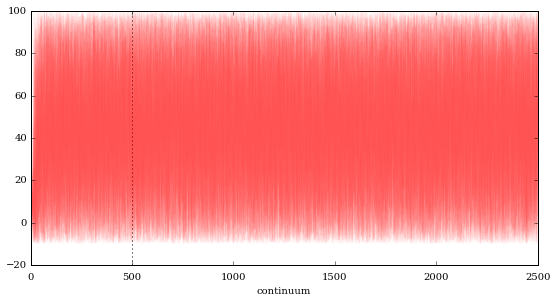

In [60]:
plot_chain(sampler_flat_uniform, par_flat, nburn=500)

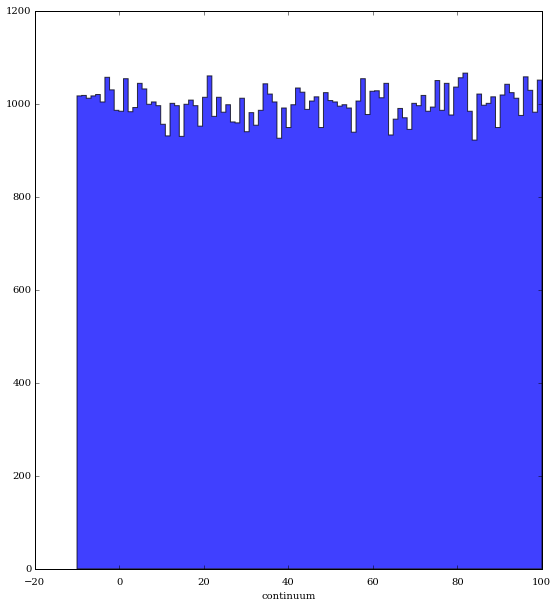

In [61]:
plot_hist(sampler_flat_uniform, par_flat, nburn=500)

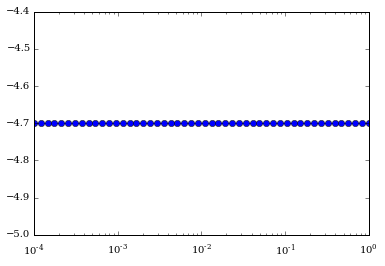

In [62]:
check_betas(sampler_flat_uniform)

In [63]:
success, sampler_flat_normal = check_unit_normalised_emcee(lnprior_flat_normal, flat_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -6.63364099488 +- 0.00809263156889
ln prior volume = 6.64639051485


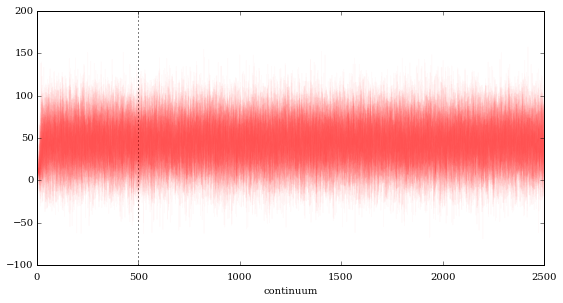

In [64]:
plot_chain(sampler_flat_normal, par_flat, nburn=500)

44.7120495864 45.0
27.4486872256 27.5


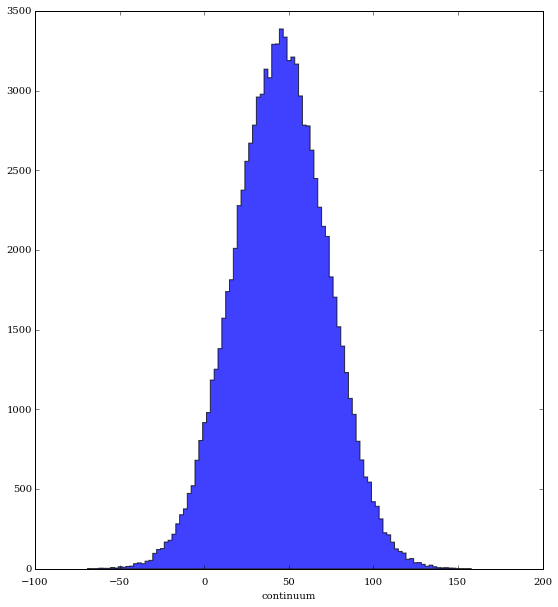

In [65]:
plot_hist(sampler_flat_normal, par_flat, nburn=500)
print(np.mean(sampler_flat_normal.chain[0].flat), 0.5*90)
print(np.std(sampler_flat_normal.chain[0].flat), 0.25*110)

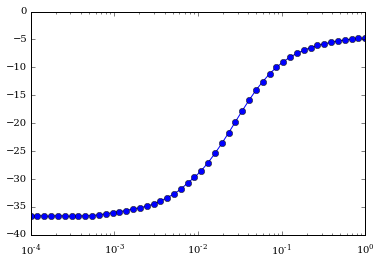

In [66]:
check_betas(sampler_flat_normal)

In [68]:
success, sampler_line_uniform = check_unit_normalised_emcee(lnprior_line_uniform, line_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -8.48382153271 +- 0.000175456731421
ln prior volume = 14.3224004469


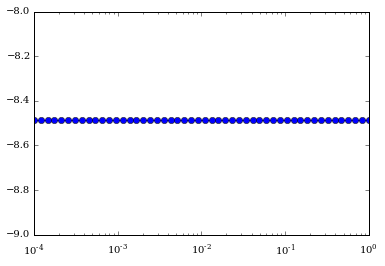

In [69]:
check_betas(sampler_line_uniform)

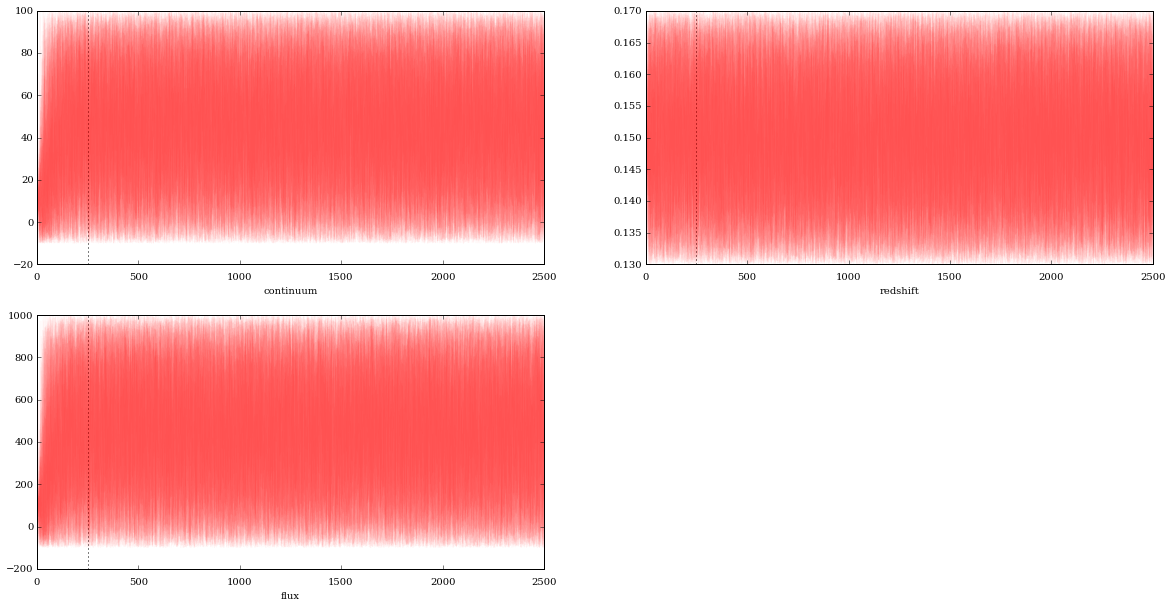

In [70]:
plot_chain(sampler_line_uniform, par_line)

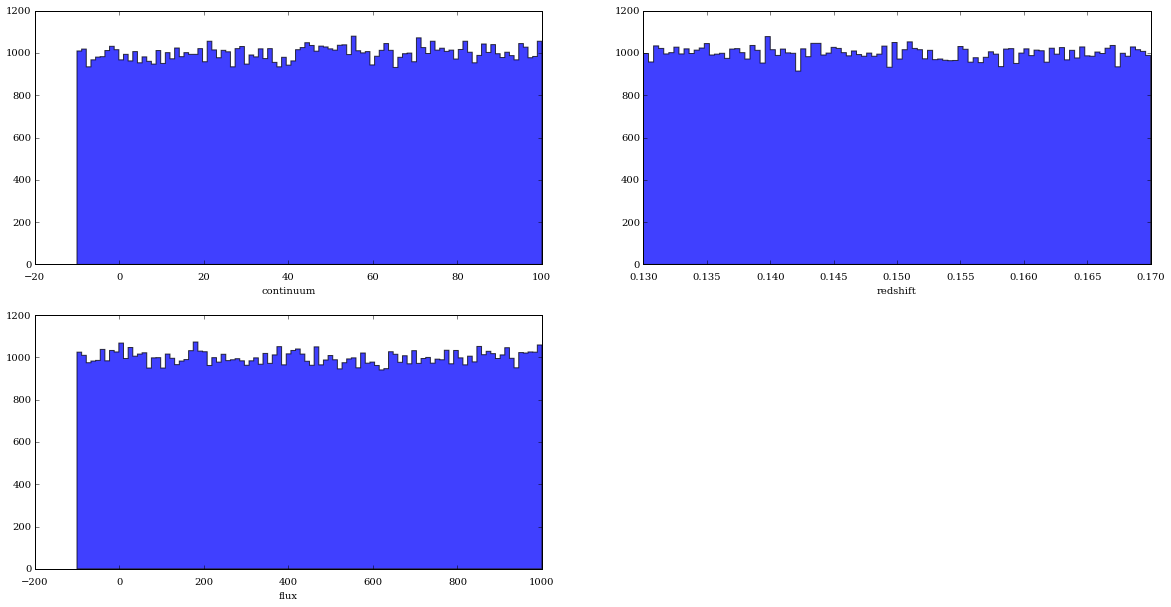

In [71]:
plot_hist(sampler_line_uniform, par_line, nburn=500)

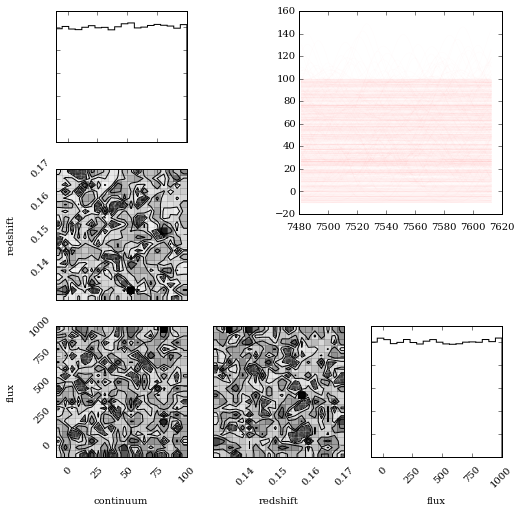

In [72]:
plot_triangle(sampler_line_uniform, par_line, line_model, xmin, xmax, [], [], [], nburn=500)

In [73]:
success, sampler_line_normal = check_unit_normalised_emcee(lnprior_line_normal, line_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -14.3079564625 +- 0.0245194904158
ln prior volume = 14.3224004469


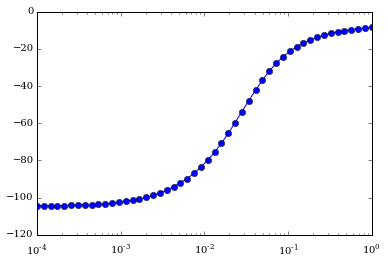

In [74]:
check_betas(sampler_line_normal)

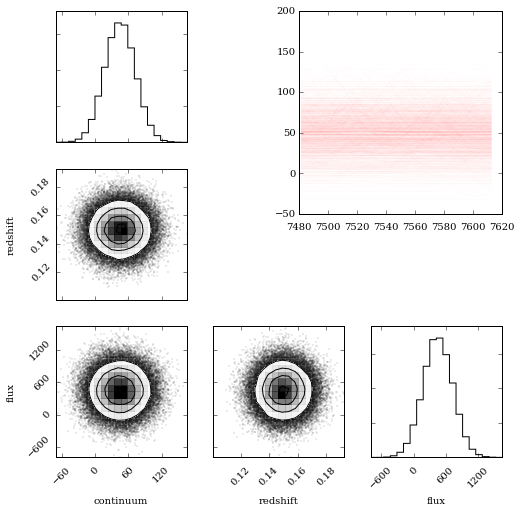

In [75]:
plot_triangle(sampler_line_normal, par_line, line_model, xmin, xmax, [], [], [], nburn=500)

In [76]:
success, sampler_line_truncnormal = check_unit_normalised_emcee(lnprior_line_truncnormal, line_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -8.48149503931 +- 0.000701014312144
ln prior volume = 14.3224004469


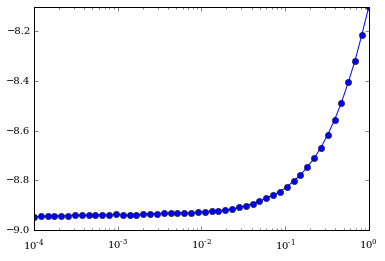

In [77]:
check_betas(sampler_line_truncnormal)

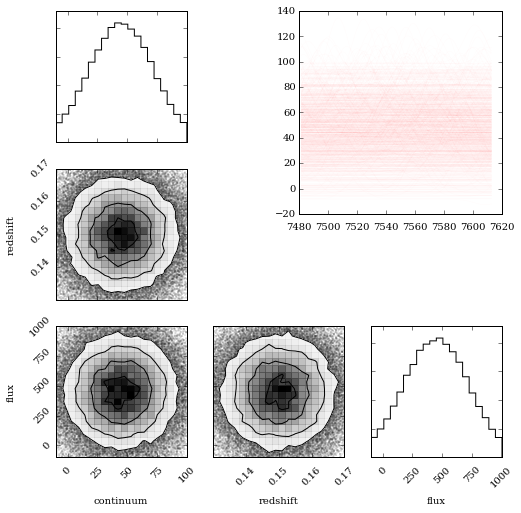

In [78]:
plot_triangle(sampler_line_truncnormal, par_line, line_model, xmin, xmax, [], [], [], nburn=500)

In [79]:
success, sampler_fixha1 = check_unit_normalised_emcee(lnprior_fixha1_uniform, fixha1_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -15.486186685 +- 0.000320274971296
ln prior volume = 23.2713760547


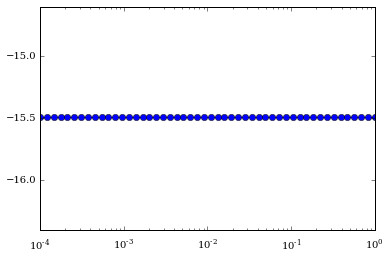

In [80]:
check_betas(sampler_fixha1)

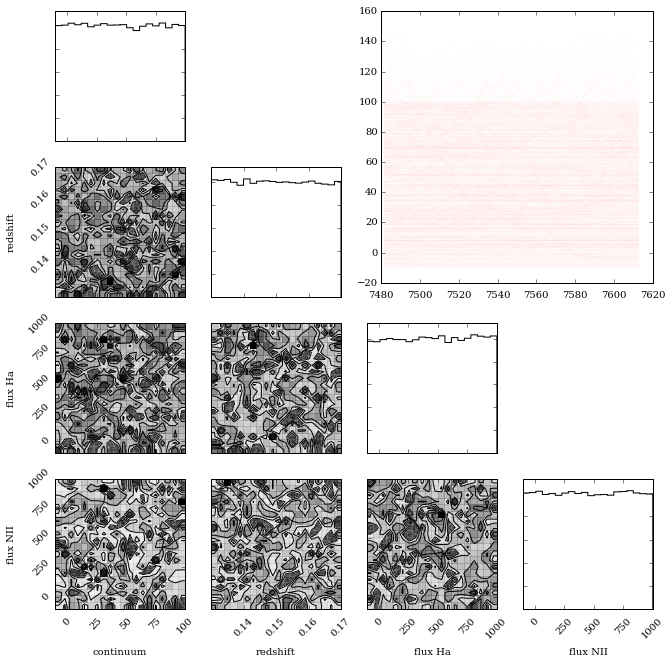

In [81]:
plot_triangle(sampler_fixha1, par_fixha, fixha_model, xmin, xmax, [], [], [], nburn=500)

In [82]:
success, sampler_fixha1_normal = check_unit_normalised_emcee(lnprior_fixha1_normal, fixha1_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -23.2748242213 +- 0.0319136928108
ln prior volume = 23.2713760547


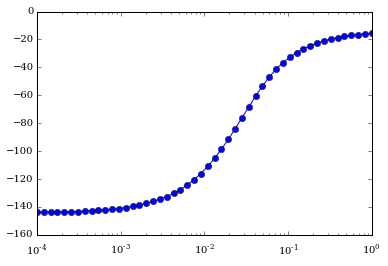

In [83]:
check_betas(sampler_fixha1_normal)

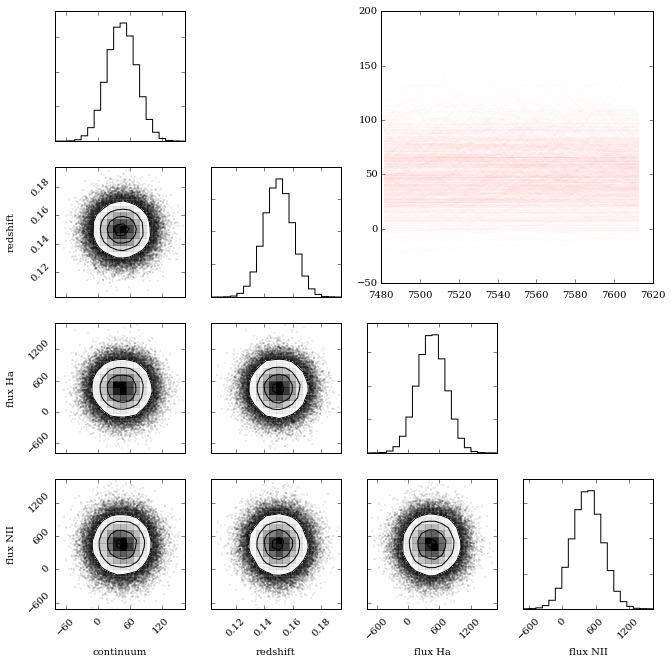

In [84]:
plot_triangle(sampler_fixha1_normal, par_fixha, fixha_model, xmin, xmax, [], [], [], nburn=500)

In [85]:
success, sampler_fixha1_better = check_unit_normalised_emcee(lnprior_fixha1_better, fixha1_better_ranges)

Steps: 250 500 750 1000 1250 1500 1750 2000 2250 2500
estimated evidence = -18.6405983001 +- 0.0353843524169
ln prior volume = 23.0100112906


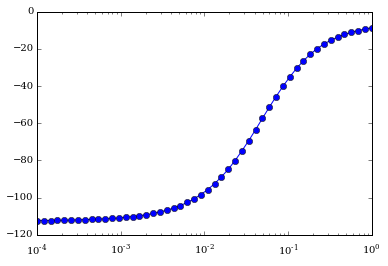

In [86]:
check_betas(sampler_fixha1_better)

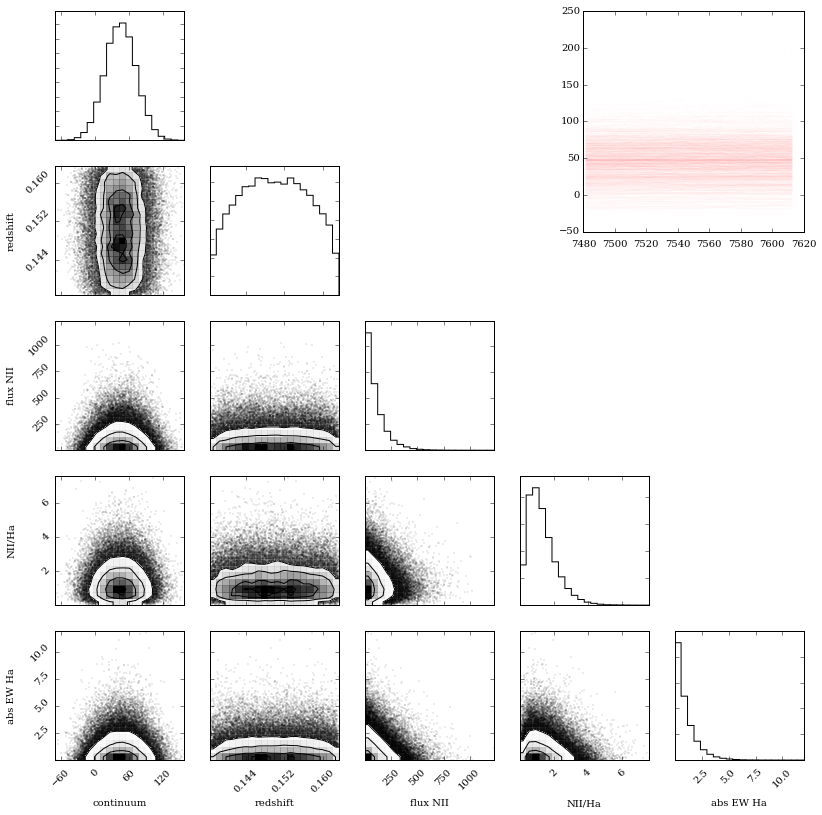

In [87]:
plot_triangle(sampler_fixha1_better, par_fixha_better, fixha_better_model, xmin, xmax, [], [], [], nburn=500)

## Likelihoods

In [184]:
def lnlikelihood(model, y, x, sigma):
    def func(p):
        yM = np.atleast_2d(model(x, p))
        lnL = norm_logpdf(y, yM, sigma).sum(axis=1)
        return lnL.squeeze()
    return func

In [185]:
lnlikelihood_fixha_better = lnlikelihood(fixha_better_model, y_noisy, x, sigma_true)

lnlikelihood_fixha = lnlikelihood(fixha_model, y_noisy, x, sigma_true)

lnlikelihood_line = lnlikelihood(line_model, y_noisy, x, sigma_true)

lnlikelihood_flat = lnlikelihood(flat_model, y_noisy, x, sigma_true)

## Sample posteriors

### emcee

In [161]:
nburn = 50
nsteps = 25

xmin = x.min()
xmax = x.max()
ymin = y_noisy.min()
ymax = y_noisy.max()
zmin = xmin/wlHa - 1
zmax = xmax/wlHa - 1

In [204]:
def init_p0_fixha_better(shape):
    # very broad uniform initial distributions
    np.random.seed(1234)### Establish the same random numbers every time we run it!!
    continuum_init = np.random.uniform(ymin, ymax, shape)
    redshift_init = np.random.uniform(zmin, zmax, shape)
    fluxNII_init = (np.random.uniform(ymin, ymax, shape) - ymin) * sqrt(2*pi) * 7.5
    NIIHa_init = np.random.uniform(0, 3, shape)
    absEWHa_init = np.random.uniform(0, 5, shape)
    return np.transpose([continuum_init, redshift_init, fluxNII_init, NIIHa_init, absEWHa_init])


def init_p0_fixha(shape):
    # very broad uniform initial distributions
    np.random.seed(1234)### Establish the same random numbers every time we run it!!
    c0_init = np.random.uniform(ymin, ymax, shape)
    z_init = np.random.uniform(zmin, zmax, shape)
    fha_init = (np.random.uniform(ymin, ymax, shape) - ymin) * sqrt(2*pi) * 7.5
    fnii_init = (np.random.uniform(ymin, ymax, shape) - ymin) * sqrt(2*pi) * 7.5
    return np.transpose([c0_init, z_init, fha_init, fnii_init])


def init_p0_line(shape):
    # very broad uniform initial distributions
    np.random.seed(1234)### Establish the same random numbers every time we run it!!
    c0_init = np.random.uniform(ymin, ymax, shape)
    z_init = np.random.uniform(zmin, zmax, shape)
    f_init = (np.random.uniform(ymin, ymax, shape) - ymin) * sqrt(2*pi) * 7.5
    return np.transpose([c0_init, z_init, f_init])


def init_p0_slope(shape):
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, shape)
    maxslope = (ymax-ymin)/(xmax-xmin)
    c1_init = np.random.uniform(-maxslope, maxslope, shape)
    return np.transpose([c0_init, c1_init])


def init_p0_flat(shape):
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, shape)
    return np.transpose([c0_init])

In [161]:
nburn = 500
nsteps = 250

xmin = x.min()
xmax = x.max()
ymin = y_noisy.min()
ymax = y_noisy.max()
zmin = xmin/wlHa - 1
zmax = xmax/wlHa - 1

In [160]:
def run_emcee(logl, logp, p0func,
              ntemps=50, nwalkers=50, nburn=500, nsteps=250, niter=10, minlogbeta=-6):
    betas = np.logspace(0, minlogbeta, ntemps)
    p0 = p0func((ntemps, nwalkers))
    ndim = p0.shape[-1]
    
    prior0bad = (logp(p0) == -np.inf).sum()/np.product(p0.shape)
    if prior0bad > 0:
        print('Warning: {:.2f}% of initial parameters have zero prior'.format(prior0bad*100))
    lnfunc0bad = (logl(p0) == -np.inf).sum()/np.product(p0.shape)
    if lnfunc0bad > 0:
        print('Warning: {:.2f}% of initial parameters have zero likelihood'.format(lnfunc0bad*100))
        
    sampler = emcee.PTSampler(ntemps, nwalkers, ndim, logl, logp, betas=betas)
    
    pos = p0
    print('Steps:', end='')
    sys.stdout.flush()
    for i in range(niter):
        pos, lnprob, rstate = sampler.run_mcmc(pos, nsteps)
        print(' {}'.format((i+1)*nsteps), end='')
        sys.stdout.flush()
    print()
    return sampler

In [195]:
def print_emcee(sampler, par, model, nburn, truths=None):
    mean, sigma = summary(flatten_without_burn(sampler, nburn), par, truths=truths)
    plot_triangle(sampler, par, model, xmin, xmax, x, y_noisy, sigma_true, 50)
    logz, logzerr = log_evidence(sampler, nburn)
    check_betas(sampler, nburn)

In [188]:
#%prun -D profile.dump run_emcee(lnlikelihood_fixha_better, logp, p0func, nburn=nburn, nsteps=nsteps)

Steps: 25 50 75 100 125 150 175 200 225 250
 
*** Profile stats marshalled to file u'profile.dump'. 


In [ ]:
%%px --targets 1 --noblock
# fixha
sampler_fixha = run_emcee(lnlikelihood_fixha,
                    lnprior_fixha1_normal,
                    init_p0_fixha,
                    nburn=nburn, nsteps=nsteps)

print_emcee(sampler_fixha, par_fixha, fixha_model, nburn, truths)

In [ ]:
# fixha_better
def logp(p):
    return lnprior_fixha_better(p, xmin, xmax, ymax)

sampler_fixha_better = run_emcee(lnlikelihood_fixha_better,
                    logp,
                    init_p0_fixha_better,
                    nburn=nburn, nsteps=nsteps)

print_emcee(sampler_fixha_better, par_fixha_better, fixha_better_model, nburn,
            truths=(1.0, 0.15, 10, 0.3, 0.0))

In [ ]:
# line
sampler_line = run_emcee(lnlikelihood_line,
                    lnprior_line_normal,
                    init_p0_line,
                    nburn=nburn, nsteps=nsteps)

print_emcee(sampler_line, par_line, line_model, nburn)

In [ ]:
# flat
sampler_flat = run_emcee(lnlikelihood_flat,
                    lnprior_flat_normal,
                    init_p0_flat,
                    nburn=nburn, nsteps=nsteps)

print_emcee(sampler_flat, par_flat, flat_model, nburn)

### nestle

In [269]:
def run_nestle(logl, logp, ranges, npoints=1000, method='single'):
    def logprob(p):
        return logl(p) + logp(p)

    def prior_transform(p):
        newranges = expand_ranges(ranges, 3.0)
        return (newranges[:,1] - newranges[:,0]) * p + newranges[:,0]

    ndim = len(ranges)

    res = nestle.sample(logprob, prior_transform, ndim,
                        method=method, npoints=npoints)
    
    return res
    
def print_nestle(res, par):
    print(res.summary)
    print(nestle.mean_and_cov(res.samples, res.weights))
    corner.corner(res.samples, weights=res.weights, labels=par)

In [271]:
# fixha
nestle_fixha = run_nestle(lnlikelihood_fixha,
                          lnprior_fixha1_normal,
                          fixha1_ranges)

print_nestle(nestle_fixha, par_fixha)

KeyboardInterrupt: 

In [ ]:
# fixha_better
def logp(p):
    return lnprior_fixha_better(p, xmin, xmax, ymax)

nestle_fixha_better = run_nestle(lnlikelihood_fixha_better,
                                 logp,
                                 fixha_better_ranges)

print_nestle(nestle_fixha_better, par_fixha_better)

In [ ]:
# line
nestle_line = run_nestle(lnlikelihood_line,
                          lnprior_line_normal,
                          line_ranges)

print_nestle(nestle_line, par_line)

In [ ]:
# flat
nestle_flat = run_nestle(lnlikelihood_flat,
                          lnprior_flat_normal,
                          flat_ranges)

print_nestle(nestle_flat, par_flat)

## Real data

In [ ]:
def get_data(glx, field, aper):
    filetemplate=('../plot_aper/all_spectra_hst/'
                  'F{field}_spectrum_gal_{glx}_{aper}_hst.txt')
    filename = filetemplate.format(glx=glx, field=field, aper=aper)

    f = np.loadtxt(filename, dtype='g')
    xmeans, ymeans, error_flux = f[:,:3].T

    ## Getting rid of the nan values...
    ok = np.logical_not(np.isnan(ymeans) | np.isnan(error_flux))

    error_flux[error_flux == 0] = 1.0  # ARBITRARY?!?

    xmeans = xmeans[ok]
    ymeans = ymeans[ok]
    error_flux = error_flux[ok]
    xmin = np.min(xmeans)
    xmax = np.max(xmeans)
    ymin = np.min(ymeans)
    ymax = np.max(ymeans)
    icov = 1/error_flux**2
    zmax = (xmax+20)/wlHa - 1
    zmin = (xmin-20)/wlHa - 1
    return xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax

In [ ]:
def run_glx(glx, field, aper):
    data = get_data(glx, field, aper)
    #ymeans = np.random.permutation(ymeans)  # scrambled
    #ymeans = np.random.normal(ymeans.mean(), ymeans.std(), len(ymeans))  # noise
    run_data(data, glx, field, aper)

def run_data(data, glx, field, aper):
    global nburn, nsamp
    xdata, ydata, yerror, icov, xmin, xmax, ymin, ymax, zmin, zmax = data
    ntemps = 10
    nburn = 500
    nsteps = 250

    xmin = x.min()
    xmax = x.max()
    ymin = y_noisy.min()
    ymax = y_noisy.max()
    zmin = xmin/wlHa - 1
    zmax = xmax/wlHa - 1

    lnlikelihood_fixha_better = lnlikelihood(fixha_better_model, ydata, xdata, yerror)
    lnlikelihood_fixha = lnlikelihood(fixha_model, ydata, xdata, yerror)
    lnlikelihood_line = lnlikelihood(line_model, ydata, xdata, yerror)
    lnlikelihood_flat = lnlikelihood(flat_model, ydata, xdata, yerror)
    
    # fixha
    sampler_fixha = run_emcee(lnlikelihood_fixha,
                    lnprior_fixha1_normal,
                    init_p0_fixha,
                    nburn=nburn, nsteps=nsteps)

    print_emcee(sampler_fixha, par_fixha, fixha_model, nburn, truths)

    # fixha_better

    # line
    
    # flat

    nsamples = nburn+nsamp
    while True:
        r_fixha_pt = sampler_fixha_pt.run_mcmc(p0_fixha, nsamples)
        r_slope_pt = sampler_slope_pt.run_mcmc(p0_slope, nsamples)
        r_flat_pt = sampler_flat_pt.run_mcmc(p0_flat, nsamples)

        a_exp, a_int = autocor_checks(sampler_fixha_pt, aper, field, glx, nburn, 'fixha')

        # DISABLE ITERATING FOR NOW
        break
        # Collect more samples if necessary
        p0_fixha = p0_slope = p0_flat = None
        if a_exp > nburn/10.0:
            nsamples = nburn
            nburn *= 2
            print 'Extending nburn to', nburn
        elif a_int > nsamp/100.0:
            nsamples = nsamp
            nsamp *= 2
            print 'Extending nsamp to', nsamp
        else:
            break

    acc_frac = acc_frac_checks(sampler_fixha_pt, aper, field, glx, 'fixha')

    flattable = flatten_without_burn(sampler_fixha_pt, nburn)
    prob = lnprobability_without_burn(sampler_fixha_pt, nburn)
    likel = lnlikelihood_without_burn(sampler_fixha_pt, nburn)

    # CHECK EVIDENCE IS ROBUST TO CHANGES IN PRIOR NORMALISATIONS
    # AND CHANGES IN TEMPERATURE SCHEDULE
    evidence_fixha = sampler_fixha_pt.thermodynamic_integration_log_evidence()
    evidence_slope = sampler_slope_pt.thermodynamic_integration_log_evidence()
    evidence_flat = sampler_flat_pt.thermodynamic_integration_log_evidence()

    ### Creating the FITS file with the samplers and the probability
    cols = [pyfits.Column(name='continuum', format='E', array=flattable[:,0]),
            pyfits.Column(name='redshift', format='E', array=flattable[:,1]),
            pyfits.Column(name='flux Ha', format='E', array=flattable[:,2]),
            pyfits.Column(name='flux NII', format='E', array=flattable[:,3]),
            pyfits.Column(name='Probability', format='E', array=prob)]

    tbhdu = pyfits.new_table(pyfits.ColDefs(cols))
    phdu = pyfits.PrimaryHDU()
    phdu.header['A_EXP'] = a_exp
    phdu.header['A_INT'] = a_int
    phdu.header['ACC_FRAC'] = acc_frac
    phdu.header['EV_FIXHA'] = evidence_fixha
    phdu.header['EV_SLOPE'] = evidence_slope
    phdu.header['EV_FLAT'] = evidence_flat
    hdulist = pyfits.HDUList([phdu, tbhdu])
    hdulist.writeto((output_path + 'table_{glx}.fits').format(
        aper=aper, field=field, glx=glx))

    plot_chain(sampler_fixha_pt, par_fixha, aper, field, glx, label='fixha')
    plot_chain(sampler_slope_pt, par_slope, aper, field, glx, label='slope')
    plot_chain(sampler_flat_pt, par_flat, aper, field, glx, label='flat')

    plot_hist(sampler_fixha_pt, par_fixha, aper, field, glx, label='fixha')
    plot_hist(sampler_slope_pt, par_slope, aper, field, glx, label='slope')
    plot_hist(sampler_flat_pt, par_flat, aper, field, glx, label='flat')

    plot_func(sampler_fixha_pt, fixha_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='fixha')
    plot_func(sampler_slope_pt, slope_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='slope', model_pars=[x0])
    plot_func(sampler_flat_pt, flat_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='flat')

    plot_triangle(sampler_fixha_pt, par_fixha, fixha_model, aper, field, glx,
                  xmin, xmax, xmeans, ymeans, error_flux, label='fixha')
    plot_triangle(sampler_slope_pt, par_slope, slope_model, aper, field, glx,
                  xmin, xmax, xmeans, ymeans, error_flux, label='slope', model_pars=[x0])